In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#zip_path = '/content/drive/MyDrive/data.zip'
#!cp "{zip_path}" .
#!unzip -q data.zip
#!rm data.zip

In [3]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import math
from sklearn.metrics import auc
import numpy as np
import cv2
import os, sys


int_ = lambda x: int(round(x))


def IoU( r1, r2 ):
    x11, y11, w1, h1 = r1
    x21, y21, w2, h2 = r2
    x12 = x11 + w1; y12 = y11 + h1
    x22 = x21 + w2; y22 = y21 + h2
    x_overlap = max(0, min(x12,x22) - max(x11,x21) )
    y_overlap = max(0, min(y12,y22) - max(y11,y21) )
    I = 1. * x_overlap * y_overlap
    U = (y12-y11)*(x12-x11) + (y22-y21)*(x22-x21) - I
    J = I/U
    return J


def evaluate_iou( rect_gt, rect_pred ):
    # score of iou
    score = [ IoU(i, j) for i, j in zip(rect_gt, rect_pred) ]
    return score


def compute_score( x, w, h ):
    # score of response strength
    k = np.ones( (h, w) )
    score = cv2.filter2D(x, -1, k)
    score[:, :w//2] = 0
    score[:, math.ceil(-w/2):] = 0
    score[:h//2, :] = 0
    score[math.ceil(-h/2):, :] = 0
    return score


def locate_bbox( a, w, h ):
    row = np.argmax( np.max(a, axis=1) )
    col = np.argmax( np.max(a, axis=0) )
    x = col - 1. * w / 2
    y = row - 1. * h / 2
    return x, y, w, h


def score2curve( score, thres_delta = 0.01 ):
    thres = np.linspace( 0, 1, int(1./thres_delta)+1 )
    success_num = []
    for th in thres:
        success_num.append( np.sum(score >= (th+1e-6)) )
    success_rate = np.array(success_num) / len(score)
    return thres, success_rate


def all_sample_iou( score_list, gt_list):
    num_samples = len(score_list)
    iou_list = []
    for idx in range(num_samples):
        score, image_gt = score_list[idx], gt_list[idx]
        w, h = image_gt[2:]
        pred_rect = locate_bbox( score, w, h )
        iou = IoU( image_gt, pred_rect )
        iou_list.append( iou )
    return iou_list


def plot_success_curve( iou_score, title='' ):
    thres, success_rate = score2curve( iou_score, thres_delta = 0.05 )
    auc_ = np.mean( success_rate[:-1] ) # this is same auc protocol as used in previous template matching papers #auc_ = auc( thres, success_rate ) # this is the actual auc
    plt.figure()
    plt.grid(True)
    plt.xticks(np.linspace(0,1,11))
    plt.yticks(np.linspace(0,1,11))
    plt.ylim(0, 1)
    plt.title(title + 'auc={}'.format(auc_))
    plt.plot( thres, success_rate )
    plt.show()

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from seaborn import color_palette
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, utils
import copy

In [61]:
# # CONVERT IMAGE TO TENSOR

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, template_dir_path, image_name, ds_coef, template_coef, thresh_csv=None, transform=None):
        self.transform = transform
        if not self.transform:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                )
            ])
        self.template_path = list(template_dir_path.iterdir())

        self.image_name = image_name

        self.ds_coef = ds_coef
        self.template_coef = template_coef
        
        self.image_raw = cv2.imread(self.image_name)
        self.image_uncompressed = self.image_raw.copy()
        orig_w = self.image_raw.shape[1]
        orig_h = self.image_raw.shape[0]
        img_w = round(self.ds_coef * orig_w)
        img_h = round(self.ds_coef * orig_h)
        self.image_raw = cv2.resize(self.image_raw, (img_w, img_h), interpolation = cv2.INTER_LINEAR) 
        
        self.thresh_df = None
        if thresh_csv:
            self.thresh_df = pd.read_csv(thresh_csv)
            
        if self.transform:
            self.image = self.transform(self.image_raw).unsqueeze(0)
        
    def __len__(self):
        return len(self.template_names)
    
    def __getitem__(self, idx):

        template_path = str(self.template_path[idx])
        template = cv2.imread(template_path)

        width = round(template.shape[1] * self.ds_coef * self.template_coef )
        height = round(template.shape[0] * self.ds_coef * self.template_coef )
        template = cv2.resize(template, (width, height), interpolation = cv2.INTER_LINEAR) 

        if self.transform:
            template = self.transform(template)
        thresh = 1.0
        if self.thresh_df is not None:
            if self.thresh_df.path.isin([template_path]).sum() > 0:
                thresh = float(self.thresh_df[self.thresh_df.path==template_path].thresh)
        return {'image': self.image, 
                    'image_raw': self.image_raw, 
                    'image_unc': self.image_uncompressed, 
                    'image_name': self.image_name,
                    'template': template.unsqueeze(0), 
                    'template_name': template_path, 
                    'template_h': template.size()[-2],
                   'template_w': template.size()[-1],
                   'thresh': thresh}

In [90]:
class Featex():
    def __init__(self, model, use_cuda):
        self.use_cuda = use_cuda
        self.feature1 = None
        self.feature2 = None
        self.model= copy.deepcopy(model.eval())
        self.model = self.model[:17]
        for param in self.model.parameters():
            param.requires_grad = False
        if self.use_cuda:
            self.model = self.model.cuda()
        self.model[2].register_forward_hook(self.save_feature1)
        self.model[16].register_forward_hook(self.save_feature2)
        
    def save_feature1(self, module, input, output):
        self.feature1 = output.detach()
    
    def save_feature2(self, module, input, output):
        self.feature2 = output.detach()
        
    def __call__(self, input, mode='big'):
        if self.use_cuda:
            input = input.cuda()
        _ = self.model(input)
        if mode=='big':
            # resize feature1 to the same size of feature2
            self.feature1 = F.interpolate(self.feature1, size=(self.feature2.size()[2], self.feature2.size()[3]), mode='bilinear', align_corners=True)
        else:        
            # resize feature2 to the same size of feature1
            self.feature2 = F.interpolate(self.feature2, size=(self.feature1.size()[2], self.feature1.size()[3]), mode='bilinear', align_corners=True)
        return torch.cat((self.feature1, self.feature2), dim=1)


class MyNormLayer():
    def __call__(self, x1, x2):
        bs, _ , H, W = x1.size()
        _, _, h, w = x2.size()
        x1 = x1.view(bs, -1, H*W)
        x2 = x2.view(bs, -1, h*w)
        concat = torch.cat((x1, x2), dim=2)
        x_mean = torch.mean(concat, dim=2, keepdim=True)
        x_std = torch.std(concat, dim=2, keepdim=True)
        x1 = (x1 - x_mean) / x_std
        x2 = (x2 - x_mean) / x_std
        x1 = x1.view(bs, -1, H, W)
        x2 = x2.view(bs, -1, h, w)
        return [x1, x2]


class CreateModel():
    def __init__(self, alpha, model, use_cuda):
        self.alpha = alpha
        self.featex = Featex(model, use_cuda)
        self.I_feat = None
        self.I_feat_name = None
    def __call__(self, template, image, image_name):
        T_feat = self.featex(template)
        if self.I_feat_name is not image_name:
            self.I_feat = self.featex(image)
            self.I_feat_name = image_name
        conf_maps = None
        batchsize_T = T_feat.size()[0]
        for i in range(batchsize_T):
            T_feat_i = T_feat[i].unsqueeze(0)
            I_feat_norm, T_feat_i = MyNormLayer()(self.I_feat, T_feat_i)
            dist = torch.einsum("xcab,xcde->xabde", I_feat_norm / torch.norm(I_feat_norm, dim=1, keepdim=True), T_feat_i / torch.norm(T_feat_i, dim=1, keepdim=True))
            conf_map = QATM(self.alpha)(dist)
            if conf_maps is None:
                conf_maps = conf_map
            else:
                conf_maps = torch.cat([conf_maps, conf_map], dim=0)
        return conf_maps


class QATM():
    def __init__(self, alpha):
        self.alpha = alpha
        
    def __call__(self, x):
        batch_size, ref_row, ref_col, qry_row, qry_col = x.size()
        x = x.view(batch_size, ref_row*ref_col, qry_row*qry_col)
        xm_ref = x - torch.max(x, dim=1, keepdim=True)[0]
        xm_qry = x - torch.max(x, dim=2, keepdim=True)[0]
        confidence = torch.sqrt(F.softmax(self.alpha*xm_ref, dim=1) * F.softmax(self.alpha * xm_qry, dim=2))
        conf_values, ind3 = torch.topk(confidence, 1)
        ind1, ind2 = torch.meshgrid(torch.arange(batch_size), torch.arange(ref_row*ref_col))
        ind1 = ind1.flatten()
        ind2 = ind2.flatten()
        ind3 = ind3.flatten()
        if x.is_cuda:
            ind1 = ind1.cuda()
            ind2 = ind2.cuda()
        
        values = confidence[ind1, ind2, ind3]
        values = torch.reshape(values, [batch_size, ref_row, ref_col, 1])
        return values
    def compute_output_shape( self, input_shape ):
        bs, H, W, _, _ = input_shape
        return (bs, H, W, 1)


# # NMS AND PLOT

# ## SINGLE

def nms(score, w_ini, h_ini, thresh=0.7):
    dots = np.array(np.where(score > thresh*score.max()))
    
    x1 = dots[1] - w_ini//2
    x2 = x1 + w_ini
    y1 = dots[0] - h_ini//2
    y2 = y1 + h_ini

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    scores = score[dots[0], dots[1]]
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= 0.5)[0]
        order = order[inds + 1]
    boxes = np.array([[x1[keep], y1[keep]], [x2[keep], y2[keep]]]).transpose(2, 0, 1)
    return boxes


def plot_result(image_raw, ds_coef, image_name, boxes, show=False, save_name=None, color=(255, 0, 0)):
    # plot result
    d_img = image_raw.copy()
    for box in boxes:
        box[0][0] /= ds_coef
        box[0][1] /= ds_coef
        box[1][0] /= ds_coef
        box[1][1] /= ds_coef
        d_img = cv2.rectangle(d_img, tuple(box[0]), tuple(box[1]), color, 4)
        d_img = cv2.putText( d_img, image_name, (int(box[0][0]), int(box[0][1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 3)
    if show:
        plt.imshow(d_img)
    if save_name:
        Img = cv2.cvtColor(d_img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(save_name, Img[:,:,::-1])
    return d_img


# ## MULTI

def nms_multi(scores, w_array, h_array, thresh_list):
    indices = np.arange(scores.shape[0])
    maxes = np.max(scores.reshape(scores.shape[0], -1), axis=1)
    # omit not-matching templates
    scores_omit = scores[maxes > 0.1 * maxes.max()]
    indices_omit = indices[maxes > 0.1 * maxes.max()]
    # extract candidate pixels from scores
    dots = None
    dos_indices = None
    for index, score in zip(indices_omit, scores_omit):
        dot = np.array(np.where(score >= thresh_list[index]*score.max()))
        if dots is None:
            dots = dot
            dots_indices = np.ones(dot.shape[-1]) * index
        else:
            dots = np.concatenate([dots, dot], axis=1)
            dots_indices = np.concatenate([dots_indices, np.ones(dot.shape[-1]) * index], axis=0)
    dots_indices = dots_indices.astype(np.int)
    x1 = dots[1] - w_array[dots_indices]//2
    x2 = x1 + w_array[dots_indices]
    y1 = dots[0] - h_array[dots_indices]//2
    y2 = y1 + h_array[dots_indices]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    scores = scores[dots_indices, dots[0], dots[1]]
    order = scores.argsort()[::-1]
    dots_indices = dots_indices[order]
    
    keep = []
    keep_index = []
    while order.size > 0:
        i = order[0]
        index = dots_indices[0]
        keep.append(i)
        keep_index.append(index)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= 0.05)[0]
        order = order[inds + 1]
        dots_indices = dots_indices[inds + 1]
        
    boxes = np.array([[x1[keep], y1[keep]], [x2[keep], y2[keep]]]).transpose(2,0,1)
    return boxes, np.array(keep_index)


def plot_result_multi(image_raw, ds_coef, image_name, boxes, indices, show=False, save_name=None, color_list=None):
    d_img = image_raw.copy()
    if color_list is None:
        color_list = color_palette("hls", indices.max()+1)
        color_list = list(map(lambda x: (int(x[0]*255), int(x[1]*255), int(x[2]*255)), color_list))
    for i in range(len(indices)):
        d_img = plot_result(d_img, ds_coef, str(image_name[i]), boxes[i][None, :,:].copy(), color=color_list[indices[i]])
    if show:
        plt.imshow(d_img)
    if save_name:
        Img = cv2.cvtColor(d_img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(save_name, Img[:,:,::-1])
    return d_img


# # RUNNING

def run_one_sample(model, template, image, image_name):
    val = model(template, image, image_name)
    if val.is_cuda:
        val = val.cpu()
    val = val.numpy()
    val = np.log(val)
    
    batch_size = val.shape[0]
    scores = []
    for i in range(batch_size):
        # compute geometry average on score map
        gray = val[i,:,:,0]
        gray = cv2.resize( gray, (image.size()[-1], image.size()[-2]) )
        h = template.size()[-2]
        w = template.size()[-1]
        score = compute_score( gray, w, h) 
        score[score>-1e-7] = score.min()
        score = np.exp(score / (h*w)) # reverse number range back after computing geometry average
        scores.append(score)
    return np.array(scores)


def run_multi_sample(model, dataset):
    scores = []
    w_array = []
    h_array = []
    thresh_list = []
    for data in dataset:
        score = run_one_sample(model, data['template'], data['image'], data['image_name'])
        scores.append(score)

        w_array.append(data['template_w'])
        h_array.append(data['template_h'])
        thresh_list.append(data['thresh'])
    return np.squeeze(np.array(scores), axis=1), np.array(w_array), np.array(h_array), thresh_list


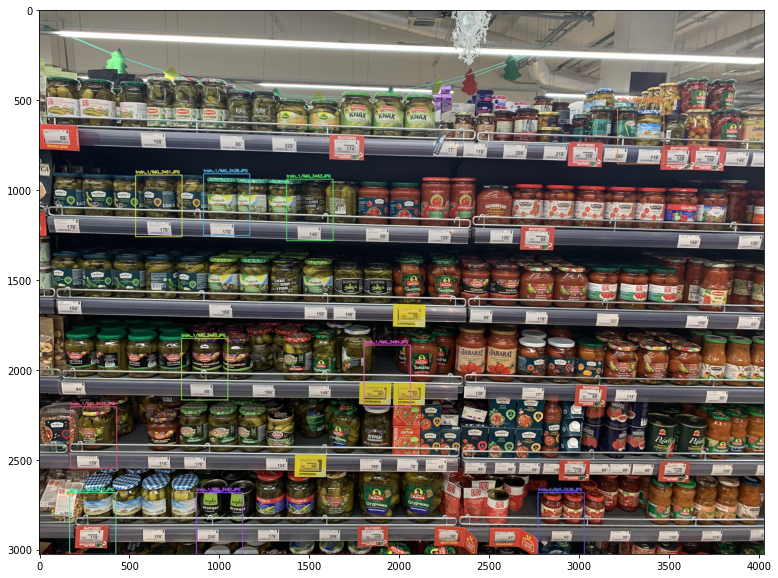

In [91]:
template_dir = 'train_1/'
image_path = '/content/drive/MyDrive/data/test/IMG_3493.JPG' 

downscale = 0.4
template_coef = 0.085

dataset = ImageDataset(Path(template_dir), image_path, downscale, template_coef)

model = CreateModel(model=models.vgg19(pretrained=True).features, alpha=25, use_cuda=True)

scores, w_array, h_array, thresh_list = run_multi_sample(model, dataset)

boxes, indices = nms_multi(scores, w_array, h_array, thresh_list)

d_img = plot_result_multi(dataset.image_uncompressed, dataset.ds_coef, dataset.template_path, boxes, indices, save_name='result_sample.png')

Img = cv2.cvtColor(d_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(Img)
plt.show()


In [89]:
str(dataset.template_path[0])

'train_1/IMG_3484.JPG'